# Instruções

Olá! Bem-vindo à atividade prática do Processo Seletivo da Minds Digital. Agradecemos o seu interesse em trabalhar conosco. Em caso de dúvidas durante a realização, por favor, entre em contato.

Nessa atividade você irá treinar um classificador simples de comandos de fala a partir do conjunto de dados "Speech Commands". Este tipo de problema possui várias aplicações práticas, tais como em assistentes de voz, controle de dispositivos por comando de voz e outras interfaces de usuário baseadas em fala.

Este Jupyter Notebook é um template em PyTorch, contendo partes do código já implementadas. A tarefa consiste em completar o código para treinar e avaliar um modelo de classificação a partir do dataset Speech Commands. No final do arquivo há uma seção extra contendo um outro dataset, que poderá ser resolvida de maneira opcional.

**ATENÇÃO: não altere trechos de código que estejam entre as tags "## NÃO ALTERAR ##". Você pode adicionar código dentro das mesmas células, se desejar, mas não altere o que estiver dentro do espaço entre essas tags.**

Caso esteja rodando o notebook no Google Colab, certifique-se de utilizar o ambiente de execução com GPU durante o treinamento. Lembre-se de adicionar comentários nas seções e partes do código que achar relevante e de manter as métricas de desempenho e outras informações úteis no notebook. <br><br> Ao final, exporte seu trabalho para um arquivo .ipynb e nos envie por e-mail.



---------------------------

In [ ]:
## NÃO ALTERAR ##
import numpy as np
import os
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import (
    Dataset,
    DataLoader
)
import torchaudio
## NÃO ALTERAR ##

import random
import matplotlib.pyplot as plt

!pip install torchsummary
from torchsummary import summary
from torch.utils.data import Subset
from torch.utils.data import random_split

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter

from IPython.display import Audio, display
import torchaudio

In [ ]:
## NÃO ALTERAR ##
# Definindo seeds para garantir reprodutibilidade
np.random.seed(42)
torch.manual_seed(42)
## NÃO ALTERAR ##

# Download do dataset

In [ ]:
## NÃO ALTERAR ##
%%capture
!wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz .
## NÃO ALTERAR ##

In [ ]:
## NÃO ALTERAR ##
!mkdir dataset
## NÃO ALTERAR ##

In [ ]:
## NÃO ALTERAR ##
%%capture
!tar -xvf speech_commands_v0.02.tar.gz -C dataset
## NÃO ALTERAR ##

In [ ]:
## NÃO ALTERAR ##
!rm -r dataset/_background_noise_
## NÃO ALTERAR ##

# Setup básico

O código abaixo divide o dataset em 3 listas: treino, validação e teste, sem intersecção.

In [ ]:
## NÃO ALTERAR ##
def list_files_recursively(org, l):
  """
  Função recursiva que lista os arquivos .wav dentro
  de uma pasta. Também considera arquivos dentro
  de subpastas.

  Args:
    org (pathlib.Path): a pasta que terá os arquivos listados
    l (List): a lista que será incrementada com os arquivos
      listados.
  """
  for item in org.iterdir():
    if os.path.isdir(item):
      list_files_recursively(item, l)
    elif item.name.endswith(".wav"):
      l.append(item)
## NÃO ALTERAR ##

## NÃO ALTERAR ##
not_in_training_files = []
with open("dataset/testing_list.txt", "r") as test:
  for line in test.readlines():
    not_in_training_files.append(line.replace("\n", ""))

with open("dataset/validation_list.txt", "r") as eval:
  for line in eval.readlines():
    not_in_training_files.append(line.replace("\n", ""))

l = []
list_files_recursively(Path("dataset"), l)

with open("dataset/train.txt", "w") as train:
  for item in l:
    name = "%s/%s" % (item.parent.name, item.name)
    if not name in not_in_training_files:
      train.writelines(f"{name}\n")
## NÃO ALTERAR ##

# Criando o dataset

Aqui **seu trabalho** começa! Mãos à obra!

Complete e valide a implementação da classe CustomAudioDataset.

Implemente a função __getitem__ para abrir os arquivos de áudio e para realizar os processamentos adequados nos áudios para garantir que eles tenham o mesmo tamanho.

Algumas dicas:
- torchaudio.transforms.MelSpectrogram calcula o espectograma de um arquivo de audio, sendo útil para trabalhar com Convolution Neural Netowrks (CNN);
- torch.nn.functional.pad é uma função útil para adequar o tamanho dos áudios

**Leandro Luna**: inicialmente, desenvolvi a classe CustomAudioDataset, responsável por carregar os arquivos de áudio e processá-los adequadamente. Notei - através de EDA e pesquisa de campo (carregando os áudios manualmente e checando o paper https://arxiv.org/pdf/1804.03209 de publicação do dataset) - que as amostras possuíam comprimentos variados, o que poderia prejudicar a consistência do treinamento. Para lidar com isso, adotei uma estratégia de padronização da duração para 1 segundo (16.000 amostras). Dessa forma, os áudios mais longos foram truncados, e os mais curtos receberam padding para garantir um tamanho uniforme. Além disso, converti os sinais de áudio em Mel Spectrograms, utilizando uma transformação logarítmica e normalização para melhorar a estabilidade do treinamento.

In [ ]:
class CustomAudioDataset(Dataset):
  def __init__(
      self,
      file_list: str,
      base: str = "dataset"
  ):
    """
    Args:
      file_list (str): a lista de arquivos que será usada
        na construção do dataset.
      dataset (str): o caminho base para os arquivos do
        dataset.
    """
    self.todos_os_arquivos = list()
    with open(file_list, "r") as mfile:
      for line in mfile.readlines():
        sample = Path(f"{base}")/line.replace("\n", "")
        self.todos_os_arquivos.append((sample, sample.parent.name)) # formato: (item, classe)
    self.class_to_idx = dict()
    self.__construct_class_to_idx()

  def __len__(self):
    """
    Retorna o número total de amostras no dataset.

    Returns:
      int: número de amostras no dataset.
    """
    return len(self.todos_os_arquivos)

  def __getitem__(self, idx):
    """
    Carrega e processa um arquivo de áudio, retornando seu espectrograma e rótulo.

    Args:
      idx (int): índice do item a ser carregado no dataset.

    Returns:
      tuple: um tupla contendo o espectrograma Mel e o rótulo (índice da classe) do arquivo de áudio.
    """
    # Obtém o caminho do arquivo e sua classe
    audio_path, class_name = self.todos_os_arquivos[idx]

    # Carrega o áudio usando torchaudio
    waveform, sample_rate = torchaudio.load(audio_path)

    # Padroniza a duração do áudio para 1 segundo (16000 samples, 16 kHz)
    target_length = 16000
    current_length = waveform.shape[1]

    if current_length > target_length:
      # Se for maior, corta
      waveform = waveform[:, :target_length]
    elif current_length < target_length:
      # Se for menor, faz padding
      padding_length = target_length - current_length
      waveform = torch.nn.functional.pad(waveform, (0, padding_length))

    # Calcula o espectrograma Mel
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
      sample_rate=sample_rate,  # Taxa de amostragem do áudio (ex: 16000 para 16 kHz).
      n_mels=64,  # Número de bandas.
      n_fft=1024,  # Tamanho da janela da FFT (Transformada Rápida de Fourier).
      hop_length=512  # Deslocamento entre as janelas de áudio para a FFT.
    )(waveform)

    # Aplica transformação logarítmica para melhor distribuição dos valores
    mel_spectrogram = torch.log(mel_spectrogram + 1e-9)

    # Normaliza os valores
    mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()

    # Obtém o índice da classe
    label = self.class_to_idx[class_name]

    return mel_spectrogram, label

  def __construct_class_to_idx(self):
    """
    Constrói o mapeamento do nome das classes para índices inteiros.
    Garante ordem consistente usando ordenação alfabética.
    """
    # Obtém lista única de classes e ordena alfabeticamente
    cls_set = sorted(list(set([y for _, y in self.todos_os_arquivos])))

    # Cria o mapeamento
    self.class_to_idx = {cl: idx for idx, cl in enumerate(cls_set)}

In [ ]:
class CustomSubset(Subset):
    def __getattr__(self, attr):
        """Tenta acessar o atributo no Subset, senão, busca no dataset original."""
        return getattr(self.dataset, attr)

# Instancie os elementos de treinamento

Crie e instancie os datasets e dataloaders relevantes para o treinamento.

Utilize os arquivos train.txt e validation_list.txt, localizados dentro da pasta "dataset".

**Leandro Luna**: com os dados devidamente processados, precisei definir a estrutura dos DataLoaders. Como o conjunto de treino era relativamente grande, ativei a opção shuffle=True para garantir que o modelo não memorizasse padrões específicos da sequência dos dados. Já no conjunto de validação, mantive shuffle=False para que os resultados fossem consistentes entre diferentes épocas. Também configurei pin_memory=True para otimizar a movimentação dos dados entre a CPU e a GPU durante o treinamento.

Após alguns experimentos do modelo, percebi que o tempo de execução estavam elevados. Diante disso, optei por utilizar apenas uma fatia dos dados do dataset (subset de 10%), o que permitiu realizar os testes do modelo de forma mais eficiente sem comprometer a análise dos resultados.

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 1
TRAIN_SUBSET_RATIO = 0.1

# Criação dos datasets
train_dataset = CustomAudioDataset("dataset/train.txt")
valid_dataset = CustomAudioDataset("dataset/validation_list.txt")

# Pegando um subconjunto aleatório de 10% do dataset de treino
train_size = int(TRAIN_SUBSET_RATIO * len(train_dataset))
train_subset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])
train_subset = CustomSubset(train_subset.dataset, train_subset.indices)

# Criação dos dataloaders
train_dataloader = DataLoader(
  train_subset,
  batch_size=BATCH_SIZE,
  shuffle=True,
  num_workers=NUM_WORKERS,
  pin_memory=True
)

val_dataloader = DataLoader(
  valid_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False,
  num_workers=NUM_WORKERS,
  pin_memory=True
)

In [ ]:
len(train_dataset), len(train_subset), len(valid_dataset)

(84843, 8484, 9981)

Assegure-se de que ambos os datasets têm o mesmo mapeamento de id para classe

In [ ]:
assert valid_dataset.class_to_idx == train_dataset.class_to_idx, "Mapeamento entre o nome das classes e os índices inteiros que as representam devem ser iguais para dataset treino e validação."
assert valid_dataset.class_to_idx == train_subset.class_to_idx, "Mapeamento entre o nome das classes e os índices inteiros que as representam devem ser iguais para subset treino e validação."

In [ ]:
def plot_waveform_and_spectrogram(dataset, index):
    """
    Plota o waveform e o Mel Spectrogram de um exemplo do dataset e exibe
    um player para escutar o áudio.

    Args:
      dataset (CustomAudioDataset): objeto do dataset.
      index (int): índice do exemplo a ser plotado.
    """
    # Aplica o processamento: padding, MelSpectrogram, log e normalização
    mel_spectrogram, label = dataset[index]

    # Recupera o nome da classe a partir do dicionário class_to_idx
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    class_name = idx_to_class[label]

    # Converte o espectrograma para numpy (removendo a dimensão do canal)
    mel_spec_np = mel_spectrogram.squeeze(0).numpy()

    # Carrega o áudio original (sem transformações) para escuta e visualização do waveform
    audio_path, _ = dataset.todos_os_arquivos[index]
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform_np = waveform.squeeze(0).numpy()

    # Plota o waveform e o Mel Spectrogram
    plt.figure(figsize=(14, 5))

    # Plot do waveform
    plt.subplot(1, 2, 1)
    plt.plot(waveform_np)
    plt.title(f"Waveform (Classe: {class_name})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")

    # Plot do Mel Spectrogram
    plt.subplot(1, 2, 2)
    plt.imshow(mel_spec_np, aspect='auto', origin='lower', interpolation='none')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency bins")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    # Exibe um player de áudio para que seja possível escutar o áudio
    display(Audio(waveform_np, rate=sample_rate))

**Leandro Luna**: além disso, fiz uma análise da distribuição das classes no conjunto de treino para verificar possíveis desbalanceamentos.

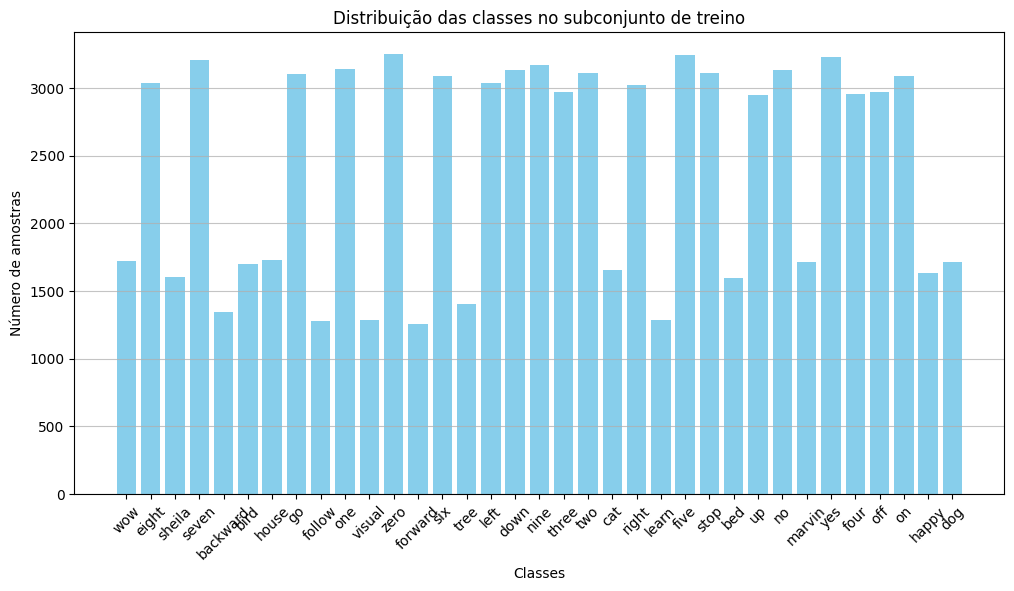

In [ ]:
classes_train = [classe for _, classe in train_subset.todos_os_arquivos]
counter = Counter(classes_train)

plt.figure(figsize=(12, 6))
plt.bar(counter.keys(), counter.values(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Número de amostras")
plt.title("Distribuição das classes no subconjunto de treino")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

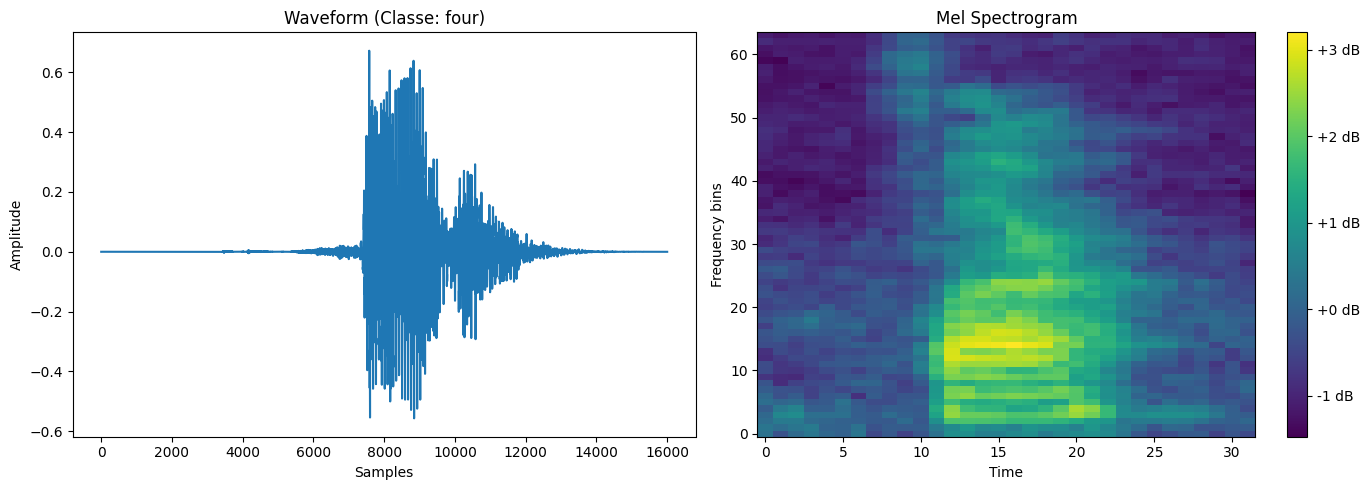

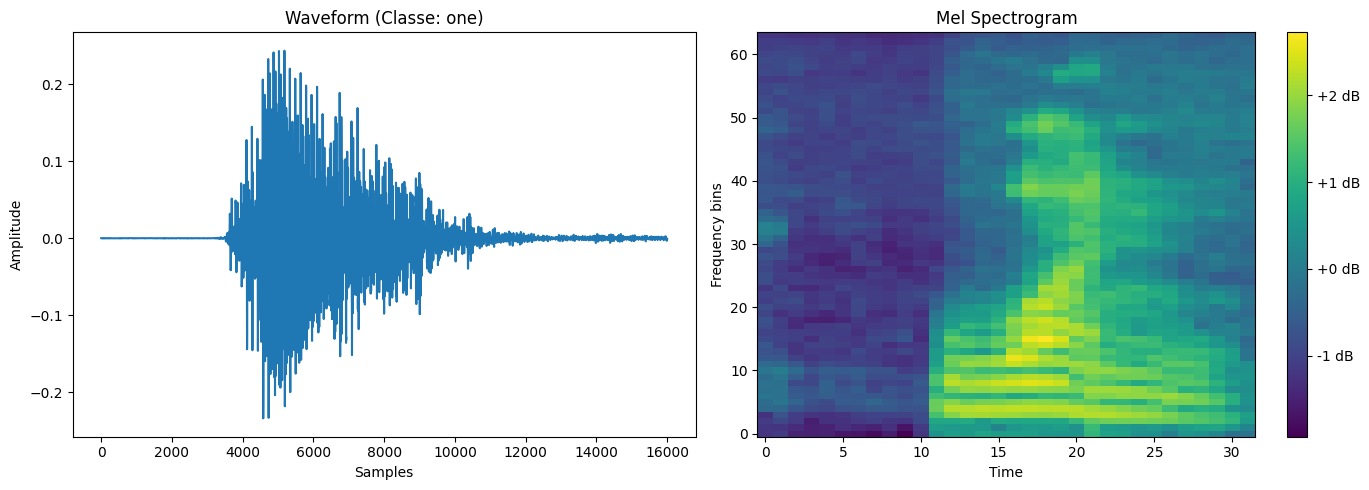

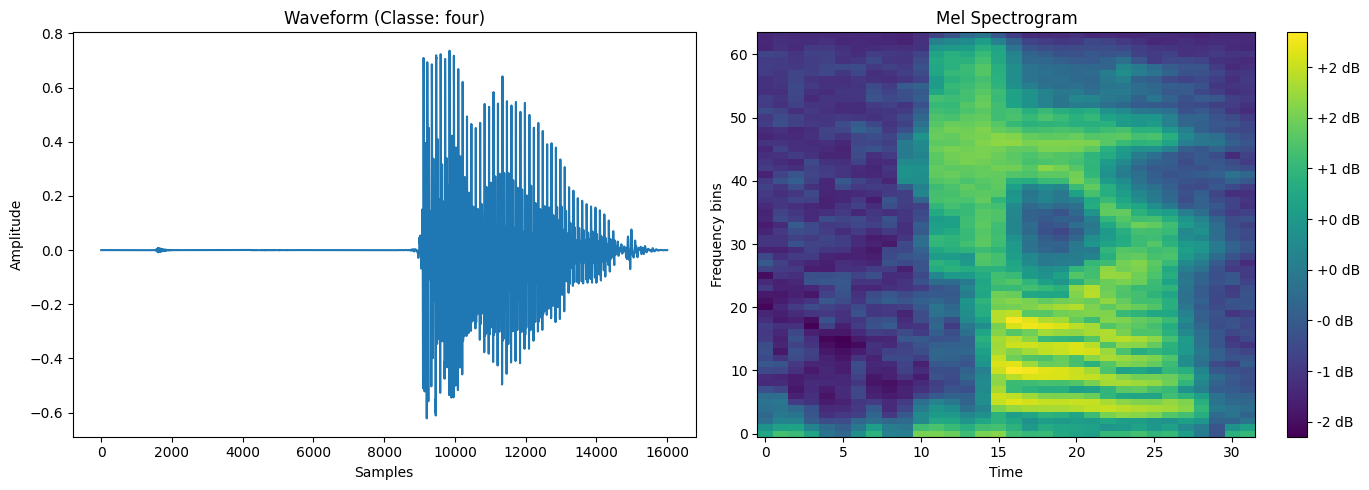

In [ ]:
# Plotando alguns exemplos aleatórios de waveform e Mel Spectrogram
num_exemplos = 3
indices_exemplos = random.sample(range(len(train_subset)), num_exemplos)
for idx in indices_exemplos:
    plot_waveform_and_spectrogram(train_subset, idx)

Instancie o seu modelo. Você tem total liberdade para escolher qual arquitetura utilizar.


**Leandro Luna**: para o modelo, decidi utilizar uma rede neural convolucional (CNN), dado que espectrogramas possuem padrões espaciais que podem ser bem explorados por convoluções. O modelo AudioCNN foi projetado com três blocos convolucionais, cada um seguido de Batch Normalization, ReLU e MaxPooling. Essa estrutura permitiu a extração eficiente de características relevantes dos espectrogramas, reduzindo gradualmente a dimensionalidade dos dados.

Para evitar overfitting, adicionei um Dropout de 50% na camada totalmente conectada antes da classificação final.

In [ ]:
idx = 0
mel_spectrogram, label = train_subset[idx]

# Exibe o shape do espectrograma para criar a primeira camada de convolução do modelo
print(f"Shape do espectrograma: {mel_spectrogram.shape}") # [1, 64, 32]

# 1 é a dimensão do canal.
# 64 é o número de bandas Mel, ou seja, o número de características frequenciais do espectrograma.
# 32 é o número de frames no tempo, ou seja, o número de janelas temporais sobre o qual o espectrograma foi calculado.

Shape do espectrograma: torch.Size([1, 64, 32])


In [ ]:
class AudioCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Convolução 2D com 1 entrada (espectrograma com 1 canal) e 32 saídas (filtros), kernel de tamanho 3x3
      nn.BatchNorm2d(32),  # Normalização da saída da convolução para melhorar a convergência
      nn.ReLU(),  # Função de ativação ReLU
      nn.MaxPool2d(2)  # MaxPooling com tamanho de pool 2x2 para reduzir dimensões espaciais
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )

    # Calculando o tamanho do tensor após as convoluções, e passando para camadas totalmente conectadas.
    self.fc1 = nn.Linear(128 * 8 * 4, 256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, num_classes)

  # Define como os dados fluem através da rede.
  def forward(self, x):
    # A entrada é passada por todas as camadas convolucionais.
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1) # Achata o tensor
    x = torch.relu(self.fc1(x)) # Passa pela primeira camada totalmente conectada com ReLU
    x = self.dropout(x) # Aplica o dropout
    x = self.fc2(x) # Passa pela camada final para a saída
    return x

# Instanciando o modelo
model = AudioCNN(num_classes=len(train_subset.class_to_idx))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, (1, 64, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 32]             320
       BatchNorm2d-2           [-1, 32, 64, 32]              64
              ReLU-3           [-1, 32, 64, 32]               0
         MaxPool2d-4           [-1, 32, 32, 16]               0
            Conv2d-5           [-1, 64, 32, 16]          18,496
       BatchNorm2d-6           [-1, 64, 32, 16]             128
              ReLU-7           [-1, 64, 32, 16]               0
         MaxPool2d-8            [-1, 64, 16, 8]               0
            Conv2d-9           [-1, 128, 16, 8]          73,856
      BatchNorm2d-10           [-1, 128, 16, 8]             256
             ReLU-11           [-1, 128, 16, 8]               0
        MaxPool2d-12            [-1, 128, 8, 4]               0
           Linear-13                  [-1, 256]       1,048,832
          Dropout-14                  [

Instancie as outras estruturas necessárias para realizar o treinamento utilizando PyTorch.

**Leandro Luna**: para a otimização do modelo, optei pelo otimizador Adam, que combina várias vantagens em tarefas complexas como a classificação de áudio. O Adam adapta automaticamente as taxas de aprendizado para cada parâmetro, o que melhora a convergência do modelo e reduz a necessidade de ajustes manuais dos hiperparâmetros, além de ser mais robusto a dados ruidosos e variações na inicialização dos parâmetros. Utilizei uma taxa de aprendizado inicial de 1e-4 (0.0001).

A função de perda escolhida foi a CrossEntropyLoss, apropriada para problemas de classificação multiclasse.

Além disso, adicionei um scheduler (ReduceLROnPlateau), que reduz a taxa de aprendizado sempre que a perda de validação não melhora por um determinado número de épocas, ajudando a evitar estagnação durante o treinamento e a melhorar a convergência do modelo.

In [ ]:
# Otimizador e função de perda
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Scheduler para ajustar a taxa de aprendizado
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer, mode='min', factor=0.5, patience=5, verbose=False
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Implemente as métricas de validação. Quais são as métricas que você pode utilizar para avaliar a perfomance de classificação do modelo treinado?

Dica: você não precisa escrevê-las do zero se não quiser. É possível utilizar o pytorch-ignite ou sklearn, por exemplo

**Leandro Luna**: sem muito segredo, a função `calculate_metrics` foi criada para calcular as métricas comuns de avaliação de modelos utilizados para classificação, como acurácia, precisão, recall e F1, utilizando os valores reais (`y_true`) e as previsões (`y_pred`).

In [ ]:
def calculate_metrics(y_true, y_pred):
  """
  Função responsável por calcular as métricas de avaliação do modelo.

  Args:
    y_true: lista ou array com os valores reais (rótulos) do conjunto de dados.
    y_pred: lista ou array com as previsões do modelo para o conjunto de dados.

  Return:
    dict: Um dicionário contendo as métricas de avaliação calculadas:
      'accuracy': A acurácia do modelo.
      'precision': A precisão do modelo.
      'recall': O recall do modelo.
      'f1': A pontuação F1 do modelo.
  """
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(
      y_true, y_pred, average='weighted'
  ) #  Cálculo ponderado
  return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
  }

# Implemente o loop de treinamento

- Implemente o loop de treinamento. Ele precisa:
  - **Atualizar** os pesos do modelo de acordo com os dados de treinamento (listados em train.txt) e fornecer uma métrica de treino por época.
  - Com alguma frequência (a seu critério), **calcular** e **informar** as métricas de validação do modelo em treinamento de acordo com os dados de validação (listados em validation_list.txt)

OBS: tenha em mente que você tem recursos limitados no Google Colab na versão free. Se eles acabarem durante o treinamento, você pode perder as variáveis que estavam carregadas em memória! Dimensione o treinamento para evitar esse tipo de problema.


In [ ]:
def train(model, dataloader, criterion, optimizer, device):
  """
  Função responsável por treinar o modelo de aprendizado de máquina.

  Args:
    model: o modelo de aprendizado de máquina a ser treinado.
    dataloader: o iterador que fornece os lotes de dados de treinamento.
    criterion: a função de perda (loss function) usada para calcular o erro entre as previsões e os valores reais.
    optimizer: o otimizador que ajusta os parâmetros do modelo durante o treinamento.
    device: o dispositivo (CPU ou GPU) em que os cálculos serão realizados.

  Return:
    train_loss (float): a perda média (loss) durante o treinamento.
    train_accuracy (float): a acurácia do modelo no conjunto de dados de treinamento.
  """
  model.train() # Coloca o modelo no modo de treinamento, permitindo ajustes nos parâmetros.
  train_loss = 0
  train_predictions = []
  train_targets = []

  for data, target in dataloader:
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad() # Limpa os gradientes acumulados do passo anterior.
    output = model(data) #  Passa os dados através do modelo para obter as previsões.
    loss = criterion(output, target) # Calcula a perda entre as previsões e os alvos reais.

    loss.backward() # Calcula o gradiente da perda em relação aos parâmetros do modelo.
    optimizer.step() #  Ajusta os parâmetros do modelo com base nos gradientes calculados.

    train_loss += loss.item() # Acumula o valor da perda para calcular a média no final.
    pred = output.argmax(dim=1).cpu().numpy() # Obtém a previsão final do modelo (classe com maior probabilidade) e a converte para um array NumPy.
    train_predictions.extend(pred) # Adiciona as previsões ao acumulador de previsões.
    train_targets.extend(target.cpu().numpy()) # Adiciona os alvos reais ao acumulador de alvos.

  # Calcula métricas de treino
  train_accuracy = sum(1 for p, t in zip(train_predictions, train_targets) if p == t) / len(train_targets) #  Calcula a acurácia como a fração de previsões corretas.
  train_loss /= len(dataloader) # Calcula a média da perda (loss) dividindo pela quantidade de lotes.

  return train_loss, train_accuracy

In [ ]:
def evaluate(model, dataloader, criterion, device):
  """
  Função responsável por validar o modelo de aprendizado de máquina.

  Args:
    model: o modelo de aprendizado de máquina que foi treinado e será avaliado.
    dataloader: o iterador que fornece os lotes de dados de validação.
    criterion: a função de perda (loss function) usada para calcular o erro entre as previsões e os valores reais.
    device: o dispositivo (CPU ou GPU) em que os cálculos serão realizados.

  Return:
    val_loss (float): a perda média (loss) durante a validação.
    val_accuracy (float): a acurácia do modelo no conjunto de dados de validação.
  """
  model.eval()
  val_loss = 0
  val_predictions = []
  val_targets = []

  with torch.no_grad(): # Desabilita o cálculo de gradientes para economizar memória durante a validação.
    for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      val_loss += criterion(output, target).item()

      pred = output.argmax(dim=1).cpu().numpy()
      val_predictions.extend(pred)
      val_targets.extend(target.cpu().numpy())

  # Calcula métricas de validação
  val_accuracy = sum(1 for p, t in zip(val_predictions, val_targets) if p == t) / len(val_targets)
  val_loss /= len(dataloader)

  return val_loss, val_accuracy

**Leandro Luna**: inicialmente, rodei o modelo utilizando o dataset completo, porém, devido às limitações computacionais do Google Colab, o runtime frequentemente estourava. O treinamento mostrou-se demorado devido à arquitetura CNN robusta empregada, aliada ao grande volume de dados do dataset Speech Commands. Além disso, o ambiente do Google Colab conta com restrições de hardware, utilizando uma GPU T4, que não é a mais adequada para problemas mais complexos.

Para mitigar esse impacto, testei variações no número de workers e no batch_size do DataLoader, buscando um melhor equilíbrio entre consumo de memória e velocidade de processamento. No entanto, o tempo de treinamento ainda permaneceu elevado. Diante disso, optei por criar um subset do dataset original para realizar os testes do modelo, o que ajudou a contornar essa limitação e viabilizar os experimentos.

In [ ]:
NUM_EPOCHS = 20
best_val_loss = float('inf')

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

torch.cuda.empty_cache()

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    print('-' * 60)

    # Salva os valores para plotagem
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Atualiza o scheduler
    scheduler.step(val_loss)

    # Salva o melhor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/20
Train Loss: 2.9270, Val Loss: 2.5541
Train Acc: 0.2104, Val Acc: 0.3540
------------------------------------------------------------
Epoch 2/20
Train Loss: 2.5066, Val Loss: 2.1315
Train Acc: 0.3042, Val Acc: 0.4743
------------------------------------------------------------
Epoch 3/20
Train Loss: 2.1837, Val Loss: 1.8186
Train Acc: 0.3851, Val Acc: 0.5513
------------------------------------------------------------
Epoch 4/20
Train Loss: 1.9040, Val Loss: 1.5506
Train Acc: 0.4652, Val Acc: 0.6108
------------------------------------------------------------
Epoch 5/20
Train Loss: 1.6287, Val Loss: 1.3057
Train Acc: 0.5468, Val Acc: 0.6835
------------------------------------------------------------
Epoch 6/20
Train Loss: 1.4467, Val Loss: 1.1336
Train Acc: 0.5884, Val Acc: 0.7214
------------------------------------------------------------
Epoch 7/20
Train Loss: 1.2780, Val Loss: 1.0410
Train Acc: 0.6376, Val Acc: 0.7404
-----------------------------------------------------

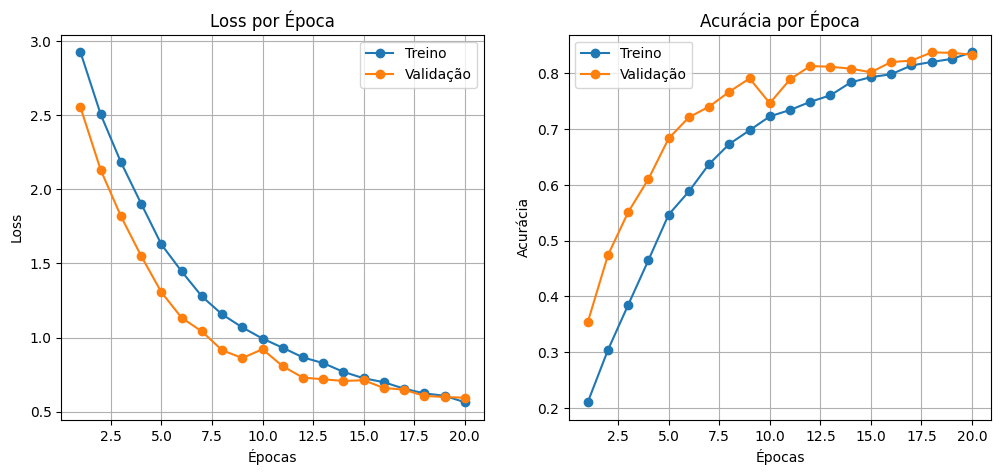

In [ ]:
# Plotando os gráficos
plt.figure(figsize=(12, 5))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Treino", marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label="Validação", marker='o')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Loss por Época")
plt.legend()
plt.grid()

# Gráfico de Acurácia
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label="Treino", marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label="Validação", marker='o')
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Acurácia por Época")
plt.legend()
plt.grid()

plt.show()

# Verifique a perfomance do modelo

**Calcule** e **apresente** as métricas de validação do modelo final de acordo com os dados de teste (listados em testing_list.txt).

In [ ]:
# Carrega o melhor modelo
model.load_state_dict(torch.load('best_model.pt'))

# Cria o dataset e dataloader de teste
test_dataset = CustomAudioDataset("dataset/testing_list.txt")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Avalia no conjunto de teste
model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
  for data, target in test_dataloader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1).cpu().numpy()
    test_predictions.extend(pred)
    test_targets.extend(target.cpu().numpy())

test_metrics = calculate_metrics(test_targets, test_predictions)
print("Métricas finais no conjunto de teste:")
print(test_metrics)

<ipython-input-88-09a9ddcc0469>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Métricas finais no conjunto de teste:
{'accuracy': 0.8231712857791913, 'precision': 0.8323393257304683, 'recall': 0.8231712857791913, 'f1': 0.821742854546628}


**Leandro Luna**: o modelo atingiu uma acurácia de aproximadamente 82%, com métricas de precisão, recall e F1-score bastante próximas. Esses valores indicam que o modelo conseguiu generalizar bem, mas ainda há espaço para melhorias.

Além disso, algumas outras estratégias poderiam ser exploradas antes de enviar o modelo para produção (deployment), entre elas:

- A implementação de MLOps pode ser uma ótima estratégia para melhorar o gerenciamento do ciclo de vida do modelo. Ferramentas como o MLflow poderiam ser utilizadas para facilitar o rastreamento das experimentações, permitindo comparar diferentes versões do modelo, acompanhar os hiperparâmetros e resultados em tempo real, além de garantir a reprodutibilidade do processo. Isso também ajudaria no monitoramento contínuo do desempenho do modelo, evitando o drift de dados e ajustando-o rapidamente a novas condições ou dados não previstos.

- O ajuste de hiperparâmetros, embora o modelo já tenha atingido uma boa performance, pode ser uma estratégia importante para alcançar resultados ainda melhores. O ajuste fino de parâmetros como o número de camadas, o tamanho do kernel e a taxa de aprendizado, por exemplo, pode melhorar significativamente a performance. Técnicas automatizadas como Grid Search ou Random Search podem ser utilizadas para explorar essas opções de forma eficiente.

- Além disso, melhorias no balanceamento de dados podem ser exploradas caso haja um desbalanceamento significativo entre as classes exploradas no dataset. Técnicas como over-sampling, under-sampling ou o uso do SMOTE podem ser utilizadas para melhorar o desempenho, especialmente nas classes minoritárias.

# Atividade Extra (opcional)

Na próxima atividade temos um problema semelhante ao problema anterior. Entretanto, a sua base de dados é muito menor: você tem apenas 6 classes, com 50 arquivos por classe para treino e 10 arquivos por classe para validação.

Como você resolveria esse problema?

In [ ]:
## NÃO ALTERAR ##
import gdown
## NÃO ALTERAR ##

In [ ]:
## NÃO ALTERAR ##
%%capture
url = "https://storage.googleapis.com/minds-public/processo_seletivo/atividade_dois.zip"
output_file = "dataset_dois.zip"

gdown.download(url, output_file)
## NÃO ALTERAR ##

In [ ]:
## NÃO ALTERAR ##
%%capture
!unzip dataset_dois.zip
!rm dataset_dois.zip
## NÃO ALTERAR ##

In [ ]:
# Bibliotecas
import os
import random

import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
from IPython.display import Audio, display

In [ ]:
# Define a seed para o módulo Random e PyTorch, afim de garantir a reprodutibilidade.
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)

**Leandro Luna**: inicialmente, percebi que o problema era particularmente delicado, pois a base de dados era extremamente limitada, com apenas 6 classes e um número reduzido de amostras por classe. Essa restrição me levou a refletir sobre os riscos de overfitting e a necessidade de extrair o máximo de informação possível de cada áudio. Dessa forma, optei por uma abordagem que unificasse o uso de transformações robustas com técnicas de data augmentation.

Logo após essa análise, decidi que seria fundamental transformar os sinais de áudio em um formato que modelos de visão já conhecidos pudessem processar de maneira eficiente. Assim, criei uma transformação “neutra” que converte os áudios em MelSpectrograms, aplica log scaling e normaliza os valores, ajustando os dados para terem três canais – garantindo compatibilidade com redes pré-treinadas.

In [ ]:
class RawCustomAudioDataset(Dataset):
  """
  Carrega os áudios e os rótulos a partir de um arquivo de texto, sem aplicar data augmentation.

  Cada linha do txt pode estar nos formatos:
      caminho/do/audio.wav  label
  ou
      caminho/do/audio.wav
  Se o rótulo não estiver informado, é inferido a partir do nome da pasta.
  """

  def __init__(self, txt_file, base=""):
    """
    Constrói o dataset a partir do arquivo de texto especificado.

    Args:
      txt_file (str): caminho do arquivo de texto contendo a lista de arquivos de áudio e seus rótulos.
      base (str, optional): caminho base para os arquivos de áudio, utilizado para construir o caminho completo. O padrão é uma string vazia.

    Processa o arquivo de texto, dividindo as linhas em caminhos e rótulos. Se o rótulo não for especificado, ele é inferido a partir da estrutura de diretórios.
    """
    self.samples = []  # Lista de tuplas (caminho, label)
    with open(txt_file, "r") as f:
      for line in f:
        line = line.strip()
        if line:
          parts = line.split()
          if len(parts) == 1:
            audio_path = os.path.join(base, parts[0])
            class_name = os.path.basename(os.path.dirname(audio_path))
            self.samples.append((audio_path, class_name))
          elif len(parts) >= 2:
            audio_path = os.path.join(base, parts[0])
            try:
              label = int(parts[1])
            except ValueError:
              label = parts[1]
            self.samples.append((audio_path, label))
          else:
            raise ValueError(f"Formato inválido na linha: {line}")
    # Se os rótulos forem strings (ou mistos), cria um mapeamento para inteiros.
    if any(isinstance(label, str) for _, label in self.samples):
      classes = sorted(set(label for _, label in self.samples))
      self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
      self.samples = [
        (audio_path, self.class_to_idx[label] if isinstance(label, str) else label)
        for audio_path, label in self.samples
      ]

  def __len__(self):
    """
    Retorna o número de amostras no dataset.

    Return:
      int: número total de amostras (caminhos de áudio) no dataset.
    """
    return len(self.samples)

  def __getitem__(self, idx):
    """
    Carrega e retorna o áudio e o rótulo correspondentes ao índice fornecido.

    Args:
      idx (int): o índice da amostra a ser recuperada.

    Return:
      tuple: Um par (waveform, label), onde:
        waveform: o tensor do áudio carregado.
        label: o rótulo correspondente ao áudio.
    """
    audio_path, label = self.samples[idx]
    waveform, sr = torchaudio.load(audio_path) # Carrega o áudio
    # Resample se necessário
    if sr != SAMPLE_RATE:
      waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    # Converte para mono, se necessário
    if waveform.shape[0] > 1: # Se o áudio for estéreo, faz a média dos canais
      waveform = waveform.mean(dim=0, keepdim=True)
    return waveform, label

In [ ]:
class TransformedDataset(Dataset):
  """
  Wrapper que aplica um transform (por exemplo, conversão para espectrograma) a cada exemplo do dataset bruto.
  Essa versão é útil para criar a versão base (sem data augmentation) dos dados.
  """

  def __init__(self, raw_dataset, transform):
    """
    Inicializa o dataset transformado com o dataset bruto e a transformação a ser aplicada.

    Args:
        raw_dataset: o dataset bruto (sem transformação) que será usado.
        transform: a transformação que será aplicada aos dados (por exemplo, espectrograma).
    """
    self.raw_dataset = raw_dataset
    self.transform = transform

  def __len__(self):
    """
    Retorna o número de exemplos no dataset transformado.

    Return:
        int: O número de amostras no dataset.
    """
    return len(self.raw_dataset)

  def __getitem__(self, idx):
    """
    Obtém um exemplo do dataset bruto, aplica a transformação e retorna o resultado com o rótulo correspondente.

    Args:
        idx (int): o índice do exemplo a ser recuperado.

    Return:
        tuple: um par contendo o dado transformado e o rótulo correspondente.
    """
    waveform, label = self.raw_dataset[idx]
    out = self.transform(waveform)
    return out, label

In [ ]:
SAMPLE_RATE = 48000
N_MELS = 64

class BaseTransform:
  """
  Transformação “neutra”: converte o áudio bruto em MelSpectrogram, aplica log scaling, normaliza e replica para 3 canais.
  """

  def __init__(self, sample_rate=SAMPLE_RATE, n_mels=N_MELS):
    """
    Inicializa a transformação com os parâmetros de taxa de amostragem e número de Mel filters.

    Args:
        sample_rate (int): taxa de amostragem do áudio.
        n_mels (int): número de Mel filters.
    """
    self.mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)

  def __call__(self, waveform):
    """
    Aplica a transformação ao áudio de entrada (waveform).

    Args:
        waveform: tensor de áudio de entrada.

    Return:
        Tensor: o espectrograma Mel transformado, com log scaling, normalizado e replicado para 3 canais.
    """
    spec = self.mel_spec(waveform)
    spec = torch.log(spec + 1e-9) # Aplica a escala logarítmica para compressão de amplitude.
    spec = (spec - spec.mean()) / (spec.std() + 1e-9) # Normaliza o espectrograma para ter média 0 e desvio padrão 1.
    spec = spec.repeat(3, 1, 1) # Replica para 3 canais para compatibilidade com redes neurais que esperam entradas RGB (3 canais).
    return spec

**Leandro Luna**: em seguida, considerando a escassez de dados, implementei um mecanismo de data augmentation que gera múltiplas versões de cada áudio. Utilizei técnicas como adição de ruído, time stretching e SpecAugment (aplicação de máscaras na frequência e no tempo), o que permitiu aumentar a variabilidade dos dados de entrada e, assim, fortalecer a capacidade de generalização do modelo.

In [ ]:
class AugmentedDataset(Dataset):
  """
  Wrapper que, para cada exemplo do dataset bruto, gera múltiplas versões aplicando um transform de data augmentation.
  """
  def __init__(self, raw_dataset, augmentation_transform, factor=2):
    """
    Inicializa o dataset aumentado com o dataset bruto, a transformação de data augmentation e o fator de aumento.

    Args:
        raw_dataset (Dataset): o dataset original contendo os exemplos brutos de áudio.
        augmentation_transform (callable): função de transformação que aplica a data augmentation ao áudio.
        factor (int, opcional): o número de versões a gerar para cada exemplo original. O valor padrão é 2.
    """
    self.raw_dataset = raw_dataset
    self.augmentation_transform = augmentation_transform
    self.factor = factor

  def __len__(self):
    """
    Retorna o número total de exemplos no dataset aumentado.

    Return:
        int: O número total de exemplos no dataset aumentado.
    """
    return len(self.raw_dataset) * self.factor # Multiplica o tamanho do dataset original pelo fator de aumento

  def __getitem__(self, idx):
    """
    Retorna um exemplo do dataset aumentado, com a aplicação de data augmentation.

    Args:
        idx (int): o índice do exemplo no dataset aumentado.

    Return:
        tuple: uma tupla contendo o áudio transformado e o rótulo associado.
    """
    base_idx = idx % len(self.raw_dataset) # Recupera o índice correspondente no dataset original
    waveform, label = self.raw_dataset[base_idx]
    out = self.augmentation_transform(waveform)
    return out, label

In [ ]:
class AudioAugmentation:
  """
  Data augmentation no domínio do áudio e do espectrograma.
  As transformações (como adição de ruído, time stretching e masking) são aplicadas de forma aleatória.
  """
  def __init__(self, sample_rate=SAMPLE_RATE, n_mels=64):
    """
    Inicializa a classe de augmentação de áudio, configurando os parâmetros necessários.

    Args:
      sample_rate (int): a taxa de amostragem do áudio.
      n_mels (int): o número de mel-filtros para o espectrograma.
    """
    self.sample_rate = sample_rate
    self.n_mels = n_mels

    # Parâmetros para augmentation no áudio
    self.noise_factor = 0.005 # Fator de intensidade do ruído adicionado
    self.time_stretch_factors = [0.8, 1.0, 1.2] # Fatores para aplicar time stretching (distorção do tempo)

    # Transformação para MelSpectrogram
    self.mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)

    # Máscaras para espectrograma (SpecAugment)
    self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)
    self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=35)

  def add_noise(self, waveform):
    """
    Adiciona ruído branco ao áudio (waveform).

    Essa transformação simula um áudio mais ruidoso, ajudando o modelo a se tornar mais robusto a variações de qualidade no sinal.

    Args:
      waveform: o tensor de áudio (sinal de áudio).

    Return:
      Tensor: o áudio com o ruído adicionado.
    """
    noise = torch.randn_like(waveform) # Gera ruído branco com a mesma forma do áudio original
    return waveform + self.noise_factor * noise

  def time_stretch(self, waveform):
    """
    Aplica a transformação de time stretching no áudio.

    O time stretching modifica a velocidade do áudio sem alterar o pitch. O fator de stretching é selecionado aleatoriamente.

    Args:
      waveform: o tensor de áudio (sinal de áudio).

    Return:
      Tensor: o áudio com o time stretching aplicado.
    """
    factor = random.choice(self.time_stretch_factors)
    if factor == 1.0:
      return waveform
    new_length = int(waveform.shape[1] / factor) # Calcula o novo comprimento do áudio após o time stretching

    # Aplica a interpolação para ajustar o comprimento do áudio, mantendo o número de canais.
    # `unsqueeze(0)` adiciona uma dimensão extra para o batch size (necessário para `interpolate`).
    # `F.interpolate` realiza a interpolação linear para ajustar o número de amostras.
    # `squeeze(0)` remove a dimensão extra de batch size após a interpolação.
    return F.interpolate(waveform.unsqueeze(0), size=new_length, mode='linear', align_corners=False).squeeze(0)

  def __call__(self, waveform):
    """
    Aplica as transformações de data augmentation de forma aleatória ao áudio (waveform).

    - Adiciona ruído com probabilidade de 50%.
    - Aplica time stretching com probabilidade de 50%.
    - Converte o áudio para um espectrograma Mel.
    - Aplica máscaras de frequência e tempo com probabilidade de 50% cada.
    - Aplica log scaling e garante que o espectrograma tenha 3 canais (compatível com modelos pré-treinados).

    Args:
      waveform: o tensor do áudio para o qual a transformação será aplicada.

    Returns:
      Tensor: o espectrograma transformado, com 3 canais.
    """
    if random.random() < 0.5:
      waveform = self.add_noise(waveform)

    if random.random() < 0.5:
      waveform = self.time_stretch(waveform)

    spec = self.mel_spec(waveform)
    if random.random() < 0.5:
      spec = self.freq_mask(spec)
    if random.random() < 0.5:
      spec = self.time_mask(spec)
    spec = torch.log(spec + 1e-9)

    # Para compatibilidade com modelos pré-treinados, garante-se 3 canais:
    if spec.shape[0] != 3:
      spec = (spec - spec.mean()) / (spec.std() + 1e-9)
      spec = spec.repeat(3, 1, 1)
    return spec

In [ ]:
def collate_fn(batch):
  """
  Função de 'colagem' que recebe um batch de tuplas (tensor, label) e realiza padding para garantir que todos os tensores tenham o mesmo comprimento na dimensão do tempo.

  Args:
    batch (list): lista de tuplas, onde cada tupla contém um tensor (representando o espectrograma) e um label associado.

  Return:
    tuple:
      tensors (Tensor): um tensor de forma (batch_size, channels, height, width), onde os tensores são empilhados e preenchidos com padding para garantir que todos tenham a
                         mesma largura (na dimensão do tempo).
      labels (Tensor): um tensor contendo os rótulos associados a cada item do batch.
  """
  # Encontra a largura máxima entre os espectrogramas
  max_width = max(item[0].shape[2] for item in batch)

  padded_tensors = []
  labels = []

  for tensor, label in batch:
    c, h, w = tensor.shape
    if w < max_width:
      # Se o comprimento (largura) do espectrograma for menor que o comprimento máximo encontrado, aplica padding à direita (na dimensão do tempo).
      pad = (0, max_width - w)  # (padding_left, padding_right)
      tensor = F.pad(tensor, pad, mode='constant', value=0)
    padded_tensors.append(tensor)
    labels.append(label)

  # Empilha os tensores e converte os rótulos para tensor
  tensors = torch.stack(padded_tensors)
  labels = torch.tensor(labels)
  return tensors, labels

**Leandro Luna**: ao analisar os dados fornecidos, notei que não havia um conjunto de testes específico. Para garantir uma avaliação confiável do modelo, decidi criar um recorte dos próprios dados brutos e separar uma parte para ser utilizada como teste. Para isso, reservei 25% das amostras do conjunto de treino original para compor o dataset de teste, mantendo os 75% restantes para o treinamento.

Além disso, nesta etapa, criei o loader para os dados de data augmentation, aumentando significativamente o número de amostras no conjunto de treino. Aqui, eu tinha duas alternativas:  
1. Expandir previamente o dataset de treino, gerando mais amostras antes do treinamento, como fiz nesta implementação.  
2. Aplicar data augmentation em tempo real, dentro dos batches de treinamento, o que reduziria a carga de processamento e o consumo de memória, tornando o treinamento mais eficiente.  

Optei pela primeira abordagem porque já havia estruturado o código dessa forma e, em algoritmos supervisionados, essa é a prática mais comum. Além disso, essa estratégia garante que o modelo tenha acesso a uma maior diversidade de amostras desde o início do treinamento, ajudando na generalização sem impactar o desempenho em tempo de execução.


In [ ]:
BATCH_SIZE = 16
NUM_WORKERS = 1

# Dados brutos sem aplicar data augmentation.
raw_train_dataset = RawCustomAudioDataset("atividade_dois/treino.txt", base="")
raw_val_dataset = RawCustomAudioDataset("atividade_dois/eval.txt", base="")

# Cria um dataset base (sem augmentation) aplicando apenas a transformação "neutra".
base_transform = BaseTransform(sample_rate=SAMPLE_RATE, n_mels=N_MELS)
base_train_dataset = TransformedDataset(raw_train_dataset, transform=base_transform)
val_dataset = TransformedDataset(raw_val_dataset, transform=BaseTransform(sample_rate=SAMPLE_RATE, n_mels=N_MELS))

# Cria um dataset para teste sem augmentation
train_size = int(0.75 * len(base_train_dataset))  # 75% para treino
test_size = len(base_train_dataset) - train_size  # 25% para teste
base_train_dataset, test_dataset = random_split(base_train_dataset, [train_size, test_size])

# Em seguida, para aumentar os samples, cria-se um dataset aumentado a partir dos dados bruto.
# Por exemplo, factor=10 gera 10 versões (com data augmentation) para cada áudio.
augmentation_transform = AudioAugmentation(sample_rate=SAMPLE_RATE, n_mels=N_MELS)
augmented_train_dataset = AugmentedDataset(raw_train_dataset, augmentation_transform=augmentation_transform, factor=10)

# Concatena base_train_dataset e augmented_train_dataset
train_dataset = ConcatDataset([base_train_dataset, augmented_train_dataset])

# Cria os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2590, 60, 61)

In [ ]:
def plot_waveform_and_spectrogram(dataset, index, sample_rate=48000):
    """
    Plota o waveform e o Mel Spectrogram de um exemplo do dataset e exibe
    um player para escutar o áudio.

    Args:
      dataset (CustomAudioDataset ou RawCustomAudioDataset): objeto do dataset.
      index (int): índice do exemplo a ser plotado.
      sample_rate (int): taxa de amostragem do áudio (default: 48000).
    """
    # Obtém o áudio e o rótulo usando o __getitem__ do dataset.
    waveform, label = dataset[index]

    # Se o dataset tiver o atributo "class_to_idx", constrói o mapeamento inverso para obter o nome da classe.
    if hasattr(dataset, 'class_to_idx'):
        idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
        class_name = idx_to_class[label] if label in idx_to_class else str(label)
    else:
        class_name = str(label)

    # Calcula o Mel Spectrogram para o áudio. Aqui utilizei uma transformação similar à aplicada nos dados.
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64, n_fft=512)
    mel_spec = mel_transform(waveform)
    mel_spec = torch.log(mel_spec + 1e-9)
    mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-9)

    # Converte o Mel Spectrogram para numpy (removendo a dimensão do canal, se houver)
    mel_spec_np = mel_spec.squeeze(0).numpy()

    # Converte o waveform para numpy para plot e reprodução (removendo a dimensão do canal, se houver)
    waveform_np = waveform.squeeze(0).numpy()

    # Plota o waveform e o Mel Spectrogram
    plt.figure(figsize=(14, 5))

    # Plot do waveform
    plt.subplot(1, 2, 1)
    plt.plot(waveform_np)
    plt.title(f"Waveform (Classe: {class_name})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")

    # Plot do Mel Spectrogram
    plt.subplot(1, 2, 2)
    plt.imshow(mel_spec_np, aspect='auto', origin='lower', interpolation='none')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency bins")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    # Exibe um player de áudio para que seja possível escutar o áudio
    display(Audio(waveform_np, rate=sample_rate))

Distribuição de classes no raw_train_dataset:
Classe 0: 40 amostras
Classe 1: 41 amostras
Classe 2: 40 amostras
Classe 3: 40 amostras
Classe 4: 40 amostras
Classe 5: 40 amostras


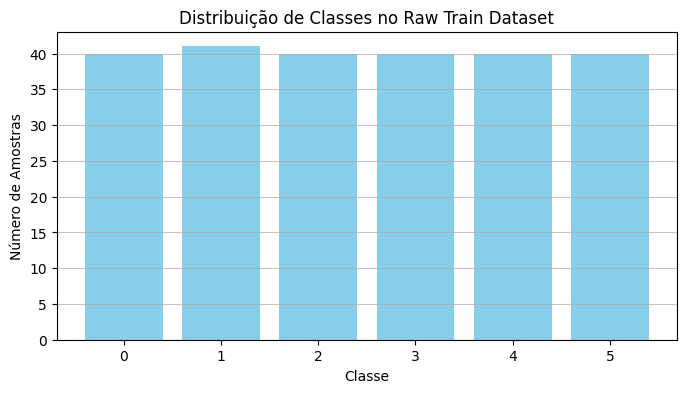

In [ ]:
labels = [label for _, label in raw_train_dataset.samples]
label_counts = Counter(labels)

print("Distribuição de classes no raw_train_dataset:")
for label, count in sorted(label_counts.items()):
    print(f"Classe {label}: {count} amostras")

plt.figure(figsize=(8, 4))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("Classe")
plt.ylabel("Número de Amostras")
plt.title("Distribuição de Classes no Raw Train Dataset")
plt.grid(axis='y', alpha=0.75)
plt.show()

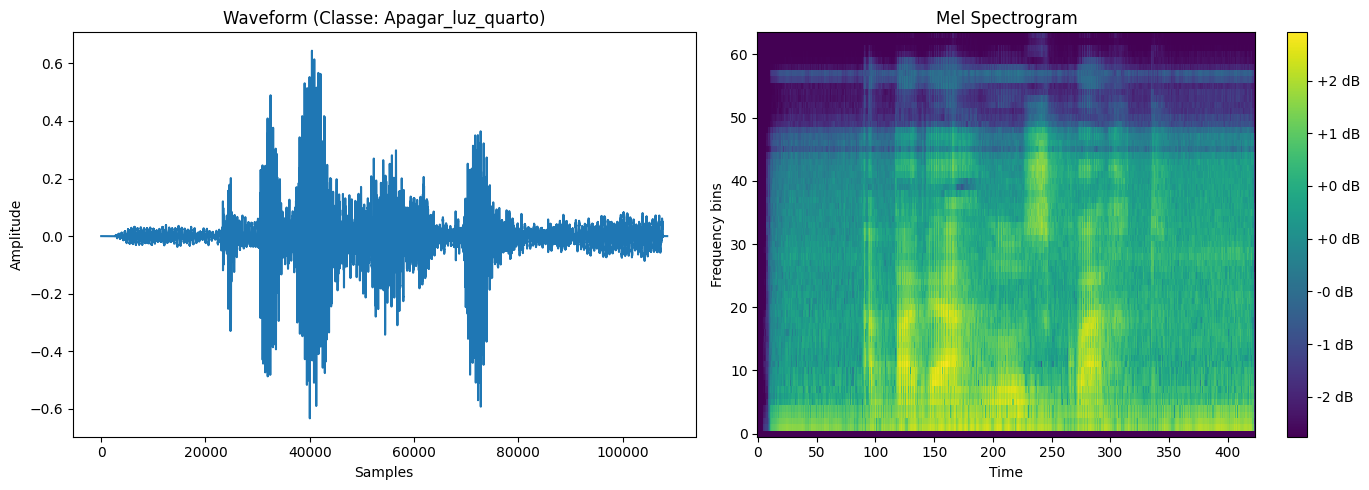

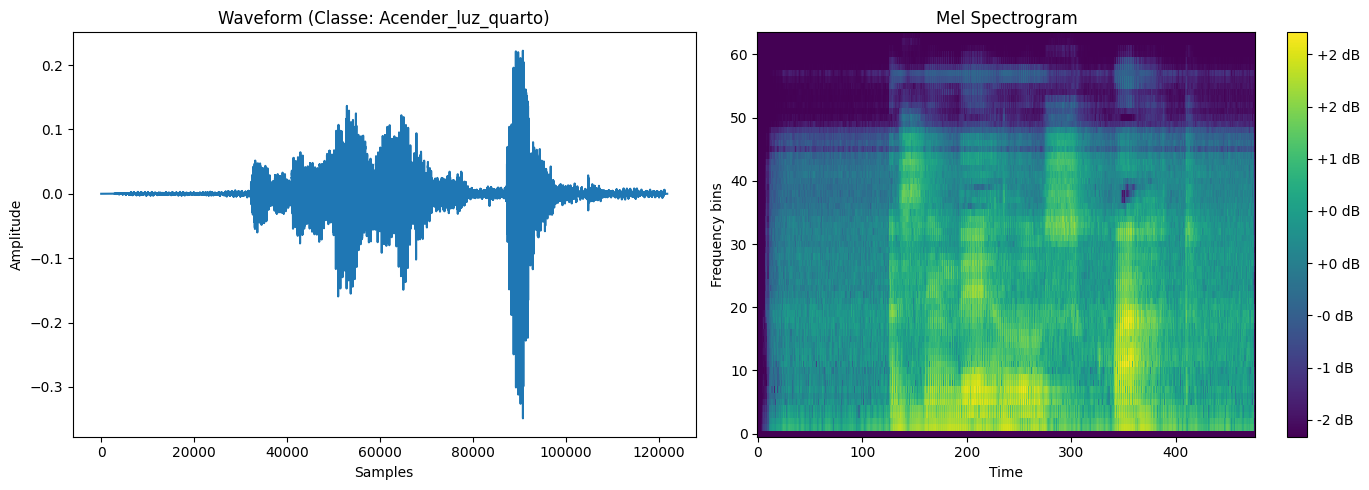

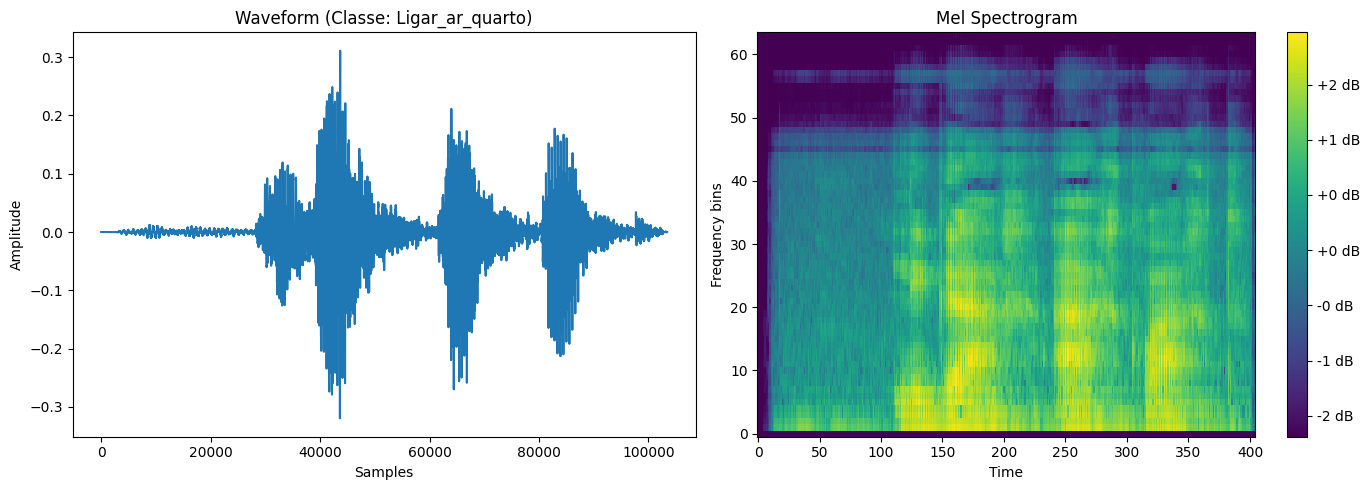

In [ ]:
num_exemplos = 3  # Número de exemplos a visualizar
indices_exemplos = random.sample(range(len(raw_train_dataset)), num_exemplos)

for idx in indices_exemplos:
    plot_waveform_and_spectrogram(raw_train_dataset, idx, sample_rate=SAMPLE_RATE)

Leandro Luna: após preparar os dados, a etapa seguinte foi definir a arquitetura do modelo. Percebi que treinar um modelo do zero com uma base tão pequena seria desvantajoso, então decidi utilizar transfer learning. Escolhi o ResNet18 pré-treinado, adaptando apenas a última camada para se ajustar às 6 classes do problema. Essa escolha me possibilitou aproveitar os padrões já aprendidos em grandes conjuntos de imagens, reduzindo significativamente o tempo de treinamento e o risco de overfitting.

In [ ]:
NUM_CLASSES = 6

# Carrega o ResNet18 pré-treinado no domínio de imagens
model = models.resnet18(pretrained=True)

# Ajusta a camada final para NUM_CLASSES
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

# Movendo para GPU se disponível
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Leandro Luna: finalmente, organizei o treinamento e a avaliação utilizando funções bem definidas para calcular métricas como acurácia, precisão, recall e F1-score. Utilizei o otimizador Adam com uma taxa de aprendizado inicial de 1e-4 (0.0001) e implementei um scheduler (ReduceLROnPlateau) para ajustar dinamicamente a taxa conforme a evolução da perda de validação.

In [ ]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Scheduler para ajustar a taxa de aprendizado
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def calculate_metrics(y_true, y_pred):
  """
  Função responsável por calcular as métricas de avaliação do modelo.

  Args:
    y_true: lista ou array com os valores reais (rótulos) do conjunto de dados.
    y_pred: lista ou array com as previsões do modelo para o conjunto de dados.

  Return:
    dict: um dicionário contendo as métricas de avaliação calculadas:
      'accuracy': a acurácia do modelo.
      'precision': a precisão do modelo.
      'recall': o recall do modelo.
      'f1': a pontuação F1 do modelo.
  """
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(
      y_true, y_pred, average='weighted'
  )
  return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
  }

In [ ]:
def train(model, loader, criterion, optimizer, device):
  """
  Função responsável por treinar o modelo de aprendizado de máquina.

  Args:
    model: o modelo de aprendizado de máquina a ser treinado.
    loader: o iterador que fornece os lotes de dados de treinamento.
    criterion: a função de perda (loss function) usada para calcular o erro entre as previsões e os valores reais.
    optimizer: o otimizador que ajusta os parâmetros do modelo durante o treinamento.
    device: o dispositivo (CPU ou GPU) em que os cálculos serão realizados.

  Return:
    epoch_loss (float): a perda média (loss) durante o treinamento.
    epoch_acc (float): a acurácia do modelo no conjunto de dados de treinamento.
  """
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    _, preds = torch.max(outputs, 1)
    correct += torch.sum(preds == labels.data)
    total += labels.size(0)

  epoch_loss = running_loss / total
  epoch_acc = correct.double() / total
  return epoch_loss, epoch_acc

In [ ]:
def evaluate(model, loader, criterion, device):
  """
  Função responsável por validar o modelo de aprendizado de máquina.

  Args:
    model: o modelo de aprendizado de máquina que foi treinado e será avaliado.
    loader: o iterador que fornece os lotes de dados de validação.
    criterion: a função de perda (loss function) usada para calcular o erro entre as previsões e os valores reais.
    device: o dispositivo (CPU ou GPU) em que os cálculos serão realizados.

  Return:
    epoch_loss (float): a perda média (loss) durante a validação.
    epoch_acc (float): a acurácia do modelo no conjunto de dados de validação.
  """
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * inputs.size(0)
      _, preds = torch.max(outputs, 1)
      correct += torch.sum(preds == labels.data)
      total += labels.size(0)

  epoch_loss = running_loss / total
  epoch_acc = correct.double() / total
  return epoch_loss, epoch_acc

In [ ]:
best_val_acc = 0.0
NUM_EPOCHS = 20

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

torch.cuda.empty_cache()

for epoch in range(NUM_EPOCHS):
  train_loss, train_acc = train(model, train_loader, criterion, optimizer, DEVICE)
  val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)

  print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
  print(f"  Train loss: {train_loss:.4f}  |  Train acc: {train_acc:.4f}")
  print(f"  Val loss:   {val_loss:.4f}  |  Val acc:   {val_acc:.4f}")

  # Salva os valores para plotar os gráficos
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc.item())
  val_accuracies.append(val_acc.item())

  # Chama o scheduler para ajustar a taxa de aprendizado com base na perda de validação
  scheduler.step(val_loss)

  # Salva o melhor modelo com base na acurácia de validação
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    torch.save(model.state_dict(), "best_model_tl.pt")

Epoch 1/20:
  Train loss: 0.6578  |  Train acc: 0.7707
  Val loss:   0.0578  |  Val acc:   0.9833
Epoch 2/20:
  Train loss: 0.1009  |  Train acc: 0.9714
  Val loss:   0.0271  |  Val acc:   1.0000
Epoch 3/20:
  Train loss: 0.0445  |  Train acc: 0.9880
  Val loss:   0.0257  |  Val acc:   0.9833
Epoch 4/20:
  Train loss: 0.0206  |  Train acc: 0.9977
  Val loss:   0.0274  |  Val acc:   0.9833
Epoch 5/20:
  Train loss: 0.0305  |  Train acc: 0.9938
  Val loss:   0.0254  |  Val acc:   1.0000
Epoch 6/20:
  Train loss: 0.0126  |  Train acc: 0.9973
  Val loss:   0.0218  |  Val acc:   0.9833
Epoch 7/20:
  Train loss: 0.0102  |  Train acc: 0.9977
  Val loss:   0.0227  |  Val acc:   0.9833
Epoch 8/20:
  Train loss: 0.0115  |  Train acc: 0.9973
  Val loss:   0.0178  |  Val acc:   1.0000
Epoch 9/20:
  Train loss: 0.0069  |  Train acc: 0.9988
  Val loss:   0.0253  |  Val acc:   1.0000
Epoch 10/20:
  Train loss: 0.0044  |  Train acc: 0.9996
  Val loss:   0.0173  |  Val acc:   1.0000
Epoch 11/20:
  Trai

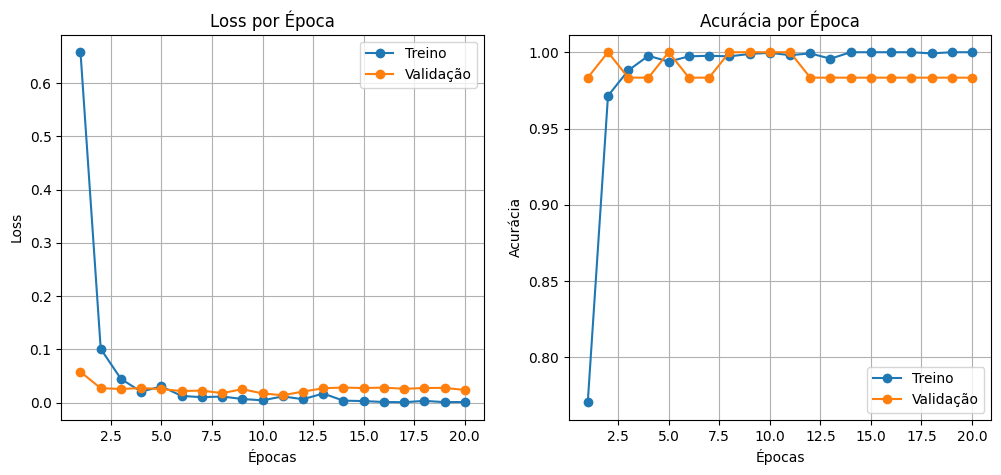

In [ ]:
plt.figure(figsize=(12, 5))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Treino", marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label="Validação", marker='o')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Loss por Época")
plt.legend()
plt.grid()

# Gráfico de Acurácia
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label="Treino", marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label="Validação", marker='o')
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Acurácia por Época")
plt.legend()
plt.grid()

plt.show()

In [ ]:
# Carrega o melhor modelo
model.load_state_dict(torch.load('best_model_tl.pt'))

# Avalia no conjunto de teste
model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE)
    output = model(data)
    pred = output.argmax(dim=1).cpu().numpy()
    test_predictions.extend(pred)
    test_targets.extend(target.cpu().numpy())

test_metrics = calculate_metrics(test_targets, test_predictions)
print("Métricas finais no conjunto de teste:")
print(test_metrics)

<ipython-input-32-545805806945>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_tl.pt'))


Métricas finais no conjunto de teste:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


Leandro Luna: percebe-se que o modelo atingiu 100% de acurácia no conjunto de teste, o que pode indicar overfitting e, em um caso mais extremo, até vazamento de dados. Esse resultado sugere que o modelo pode estar memorizando padrões específicos dos dados de treino, em vez de aprender generalizações úteis para novas amostras.  

Dessa maneira, através de um melhor entendimento do domínio de áudio (pesquisas e conversas com DMEs da área) e aplicações de augmentações mais condizentes, ou da utilização de técnicas como regularização mais agressiva (Dropout adicional, Weight Decay), aumento da diversidade dos dados de entrada com mistura de amostras (Mixup), ou até mesmo validação cruzada (Cross-Validation), seria possível realizar um novo treinamento do modelo para evitar esse problema.  

Porém, para o teste técnico nível jr., julgo que pude abordar uma sequência ideal de etapas que seriam necessárias para estruturar um pipeline de treinamento robusto, garantindo uma boa organização do fluxo de dados e uma abordagem eficiente para lidar com a escassez de amostras.